In [1]:
import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC

import joblib

from libs.container import Container
import dataset

In [2]:
def load(fname_preffix):
    df = joblib.load(f"results/{fname_preffix}_all_vs_all_table.pkl.bz2")
    df.columns = ['Tile A', 'Tile B', 'Precision', 'Recall', 'AUC']
    return df

selected_df = load("selected")
unselected_df = load("unselected")
afeats_df = load("afeats")

In [3]:
from scipy.spatial import distance

POSITIONS = {
    "b206": (13, 8),
    "b214": (13, 0),
    "b216": (12, 12),
    'b220': (12, 8),
    "b228": (12, 0),
    'b234': (11, 8),
    'b247': (10, 9),
    'b248': (10, 8),
    'b261': ( 9, 9),
    'b262': ( 9, 8),
    'b263': ( 9, 7),
    'b264': ( 9, 6),
    'b277': ( 8, 7),
    'b278': ( 8, 6),
    "b360": (2, 8),
    'b396': ( 0, 0),
}

def get_dis(row):
    ta, tb = (row["Tile A"], row["Tile B"])
    pa = list(map(float, POSITIONS[ta]))
    pb = list(map(float, POSITIONS[tb]))
    return distance.cityblock(pa, pb)

def add_distance(df):
    df["Distance"] = df.apply(get_dis, axis=1)
    return df
    
    
add_distance(selected_df)
add_distance(unselected_df)
add_distance(afeats_df)

,Tile A,Tile B,Precision,Recall,AUC,Distance
0,b206,b214,0.998502,1.0000,0.999994,8.0
1,b206,b216,0.985561,0.9215,0.987597,5.0
2,b206,b220,0.991480,0.9310,0.989641,1.0
3,b206,b228,0.998502,1.0000,0.999997,9.0
4,b206,b234,0.997463,0.9830,0.999413,2.0
...,...,...,...,...,...,...
115,b277,b360,0.989940,0.9840,0.999385,7.0
116,b277,b396,0.723920,0.7460,0.787567,15.0
117,b278,b360,0.995498,0.9950,0.999851,8.0
118,b278,b396,0.830715,0.8195,0.901490,14.0


In [4]:
from collections import Counter

df = selected_df
all_tiles = list(set(list(df["Tile A"].values) + list(df["Tile B"].values)))
all_tiles

freq = dict(Counter(df["Tile A"].values).most_common())
for t in all_tiles:
    if t not in freq:
        freq[t] = (max(freq.values()) + 100) * -1
        
del df

In [5]:
all_tiles = sorted(all_tiles, key=freq.get)
all_tiles

['b396',
 'b360',
 'b278',
 'b277',
 'b264',
 'b263',
 'b262',
 'b261',
 'b248',
 'b247',
 'b234',
 'b228',
 'b220',
 'b216',
 'b214',
 'b206']

In [6]:
def table(df, attr):
    rows = []
    for ta in all_tiles:
        row = [ta]
        for tb in all_tiles:
            try:
                flt = (df["Tile A"] == ta) & (df["Tile B"] == tb)
                v = df[flt][attr].values[0]
            except:
                v = np.nan
            row.append(v)
        if len(set(row)) != 2:
            rows.append(row)
    tab = pd.DataFrame(rows, columns=["Tile A"] + all_tiles).set_index("Tile A")
    tab = tab.dropna(axis=1, how='all')
    return tab

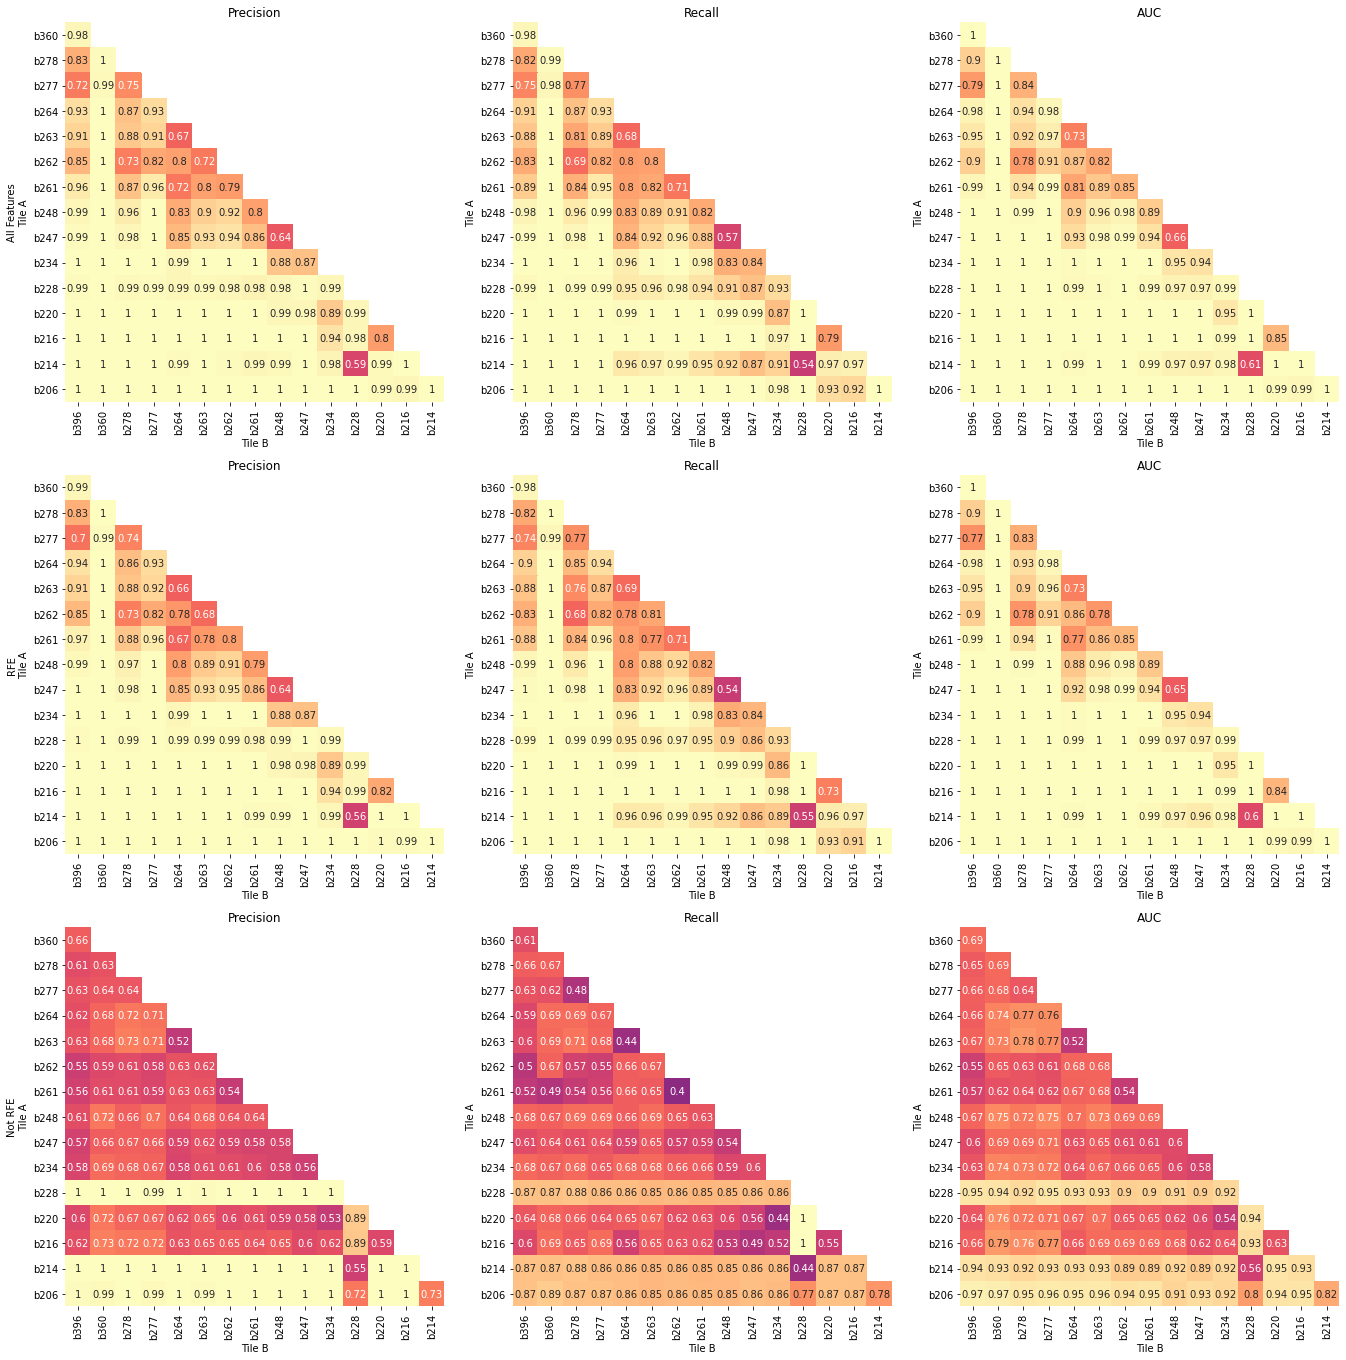

In [16]:
def plot_heatmaps(df, featureset, axes, **kwargs):
    dkwargs = dict(square=True, fmt=".2g", annot=True, cmap="magma", vmin=0, vmax=1, center=.5, cbar=False)
    dkwargs.update(kwargs)
    kwargs = dkwargs
    
    ax, name = axes[0], "Precision"
    sns.heatmap(table(df, name), ax=ax, **kwargs)
    ax.set_title(name)
    ax.set_xlabel("Tile B")

    ax, name = axes[1], "Recall"
    sns.heatmap(table(df, name), ax=ax, **kwargs)
    ax.set_title(name)
    ax.set_xlabel("Tile B")

    ax, name = axes[2], "AUC"
    sns.heatmap(table(df, name), ax=ax, **kwargs)
    ax.set_title(name)
    ax.set_xlabel("Tile B")

#     ax, name = axes[3], "Distance"
#     sns.heatmap(table(df, name), ax=ax, **kwargs)
#     ax.set_title(name)
#     ax.set_xlabel("Tile B")
    
    ax = axes[0]
    ax.set_ylabel(f"{featureset}\n{ax.get_ylabel()}")

fig, axes = plt.subplots(3, 3, figsize=(19, 19))


plot_heatmaps(afeats_df, "All Features", axes[0])
plot_heatmaps(selected_df, "RFE", axes[1])
plot_heatmaps(unselected_df, "Not RFE", axes[2])


plt.tight_layout()
plt.savefig("plots/all_vs_all.pdf")

plt.show()

In [141]:
from collections import Counter

def freq_df(df, name):
    md = df.groupby("Distance").median()
    freq = Counter(df.Distance.values)

    def get_freq(r):
        return freq[r.name]
    
    md["Count"] = md.apply(get_freq, axis=1)
    
    md.columns = pd.MultiIndex.from_product([[name], md.columns])
    return md
    

afeats_freq = freq_df(afeats_df, "All Features")
selected_freq = freq_df(selected_df, "RFE")
unselected_freq = freq_df(unselected_df, "Not-RFE")
freqs = afeats_freq.join(selected_freq).join(unselected_freq)

count = freqs[("RFE", "Count")].values
freqs = freqs.drop('Count', axis=1, level=1)
freqs["Count"] = count

In [145]:
freqs = freqs[freqs.Count >= 5]
freqs

All Features                          RFE                     \
            Precision   Recall       AUC Precision   Recall       AUC   
Distance                                                                
1.0          0.863659  0.83100  0.939697  0.861381  0.82750  0.934972   
2.0          0.892657  0.86700  0.950844  0.882898  0.86225  0.948906   
3.0          0.981141  0.97650  0.997626  0.980149  0.97650  0.998252   
4.0          0.998001  0.99850  0.999495  0.999000  0.99950  0.999505   
5.0          0.998000  0.99800  0.999102  0.998995  0.99750  0.999168   
6.0          0.998498  0.99900  0.999056  0.999500  1.00000  0.999505   
8.0          0.998501  0.99950  0.999851  0.999001  1.00000  0.999999   
9.0          0.998502  0.99900  0.999493  0.999001  1.00000  0.999566   
10.0         0.990111  0.97225  0.996449  0.993626  0.97150  0.997277   
11.0         0.995410  0.97750  0.997552  0.998269  0.97450  0.998436   
12.0         0.994712  0.98725  0.998788  0.997410  0.98775  0.999465   

           Not-RFE                    Count  
         Precision   Recall       AUC        
Distance                                     
1.0       0.581327  0.58600  0.605390    13  
2.0       0.628538  0.65325  0.676552    12  
3.0       0.610714  0.65650  0.654731    11  
4.0       0.648649  0.65200  0.701850    11  
5.0       0.672585  0.65350  0.711328     9  
6.0       0.674454  0.66400  0.722502     5  
8.0       0.676862  0.66750  0.734561     7  
9.0       0.717256  0.69000  0.773846     9  
10.0      0.996800  0.84975  0.916346     8  
11.0      0.997669  0.85950  0.917795     7  
12.0      0.997693  0.86100  0.917087     6

In [146]:
print(freqs.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{All Features} & \multicolumn{3}{l}{RFE} & \multicolumn{3}{l}{Not-RFE} & Count \\
{} &    Precision & Recall &   AUC & Precision & Recall &   AUC & Precision & Recall & \multicolumn{2}{l}{AUC} \\
Distance &              &        &       &           &        &       &           &        &       &       \\
\midrule
1.0      &        0.864 &  0.831 & 0.940 &     0.861 &  0.828 & 0.935 &     0.581 &  0.586 & 0.605 &    13 \\
2.0      &        0.893 &  0.867 & 0.951 &     0.883 &  0.862 & 0.949 &     0.629 &  0.653 & 0.677 &    12 \\
3.0      &        0.981 &  0.977 & 0.998 &     0.980 &  0.977 & 0.998 &     0.611 &  0.656 & 0.655 &    11 \\
4.0      &        0.998 &  0.999 & 0.999 &     0.999 &  1.000 & 1.000 &     0.649 &  0.652 & 0.702 &    11 \\
5.0      &        0.998 &  0.998 & 0.999 &     0.999 &  0.998 & 0.999 &     0.673 &  0.653 & 0.711 &     9 \\
6.0      &        0.998 &  0.999 & 0.999 &     1.000 &  1.000 & 1.000 &   

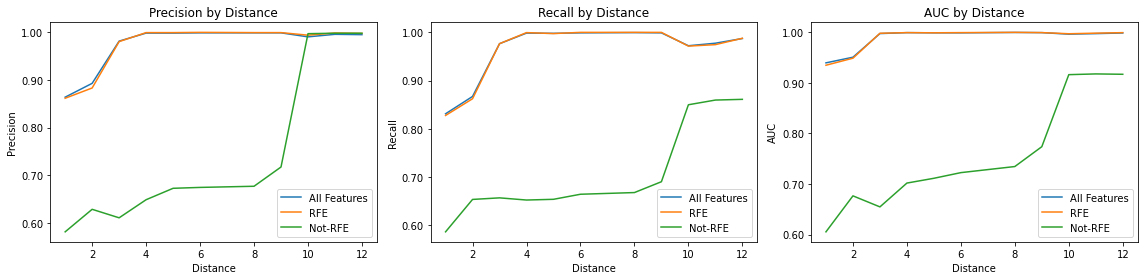

In [161]:
from matplotlib.ticker import StrMethodFormatter

def plot_by_distance(freqs, attr, ax):
    freqs.loc[:,(slice(None), attr)].droplevel(1, axis=1).plot(ax=ax)
    
    ax.set_title(f"{attr} by Distance")
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_ylabel(attr)
    
fig, axes = plt.subplots(1,3, figsize=(16, 4))
plot_by_distance(freqs, "Precision", axes[0])
plot_by_distance(freqs, "Recall", axes[1])
plot_by_distance(freqs, "AUC", axes[2])
fig.align_ylabels()
fig.tight_layout()
plt.savefig("plots/vs_distance.pdf")